<a href="https://colab.research.google.com/github/ChristianConchari/Computer-Vision-Notes/blob/master/Tutorial_11_ORB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 11: ORB

In recent years, object detection/recognition has become one of the most researched subjects in Computer Vision. Therefore, there is a huge variety of methods that range from detail-oriented algorithms  (e.g. Template Matching or Generalised Hough Transform) to more generalised algorithms(Yolo, R-CNN, Mask R-CNN). `Oriented FAST and Rotated BRIEF (ORB)` lies in the middle because it can identify specific images as faces but it is unable to generalise as needed when counting people. This is mainly because people shapes are quite variable due to clothing and posture.  

We can define object detection as the ability to recognise particular objects in images in order to determine their locations within the images. This can be nicely performed by implementing ORB, which also has some great properties, such as being invariant to rotations, illumination variance, and noise. 

In this tutorial, you will experiment with ORB to detect if an image contains an specific car model. Then, you will have to implement a similar concept with people faces.  


### 0. Image pyramids
Before starting with ORB, let's take a look at how downsampling with image pyramids works.

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


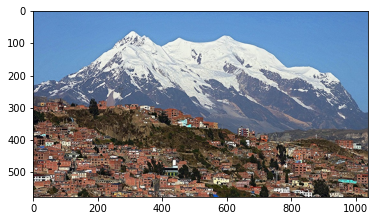

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, requests

%matplotlib inline

# Download the training image from the Internet
img_data = requests.get("https://marketingsimulator.net/asaucedo/wp-content/uploads/sites/187/2016/07/ILLIMANI1-1038x576.jpg" , verify=False).content
with open('ILLIMANI1-1038x576.jpg', 'wb') as handler:
    handler.write(img_data)

# Read in the image
image0 = cv2.imread('ILLIMANI1-1038x576.jpg')

# Change color to RGB (from BGR)
image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)

plt.imshow(image0)

Then, we will successively apply `cv2.pyrDown()` with the image and display results.

(576, 1038, 3)
(288, 519, 3)
(144, 260, 3)
(72, 130, 3)


(576.0, 0.0)

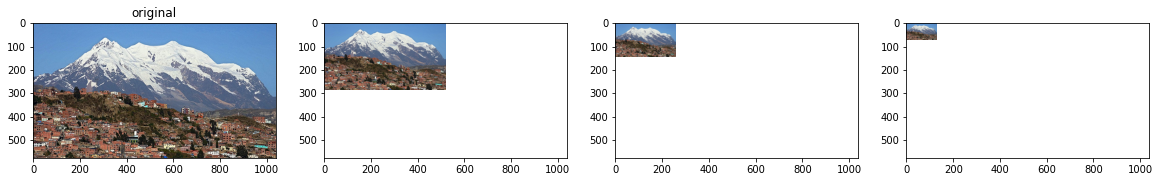

In [ ]:
# Reduce resolution. 
level_1 = cv2.pyrDown(image0)
level_2 = cv2.pyrDown(level_1)
level_3 = cv2.pyrDown(level_2)

print(image0.shape)
print(level_1.shape)
print(level_2.shape)
print(level_3.shape)


# Display the images
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10))

ax1.set_title('original')
ax1.imshow(image0)

ax2.imshow(level_1)
ax2.set_xlim([0, image0.shape[1]])
ax2.set_ylim([image0.shape[0], 0])

ax3.imshow(level_2)
ax3.set_xlim([0, image0.shape[1]])
ax3.set_ylim([image0.shape[0], 0])

ax4.imshow(level_3)
ax4.set_xlim([0, image0.shape[1]])
ax4.set_ylim([image0.shape[0], 0])

As you can see, every time we apply `cv2.pyrDown()`, we divide the image into two. For example, a four-pixel box now becomes one pixel with the average intensity in it. Now, let's start with ORB.  

### 1. Loading Images and Importing Resources

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


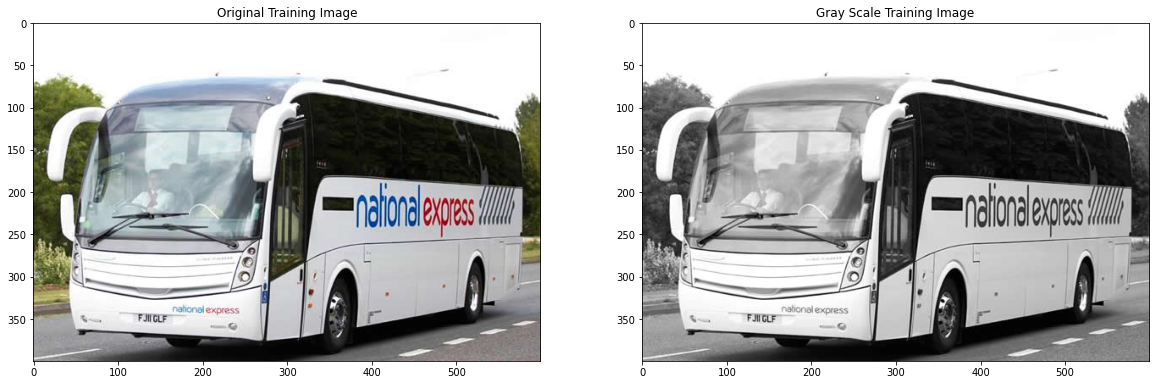

In [ ]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os, requests

# Download the training image from the Internet
img_data = requests.get("https://www.londontoolkit.com/Images/public-transport/xnational-express-coach.jpg.pagespeed.ic.C3yZCERUTs.jpg" , verify=False).content
with open('xnational-express-coach.jpg.pagespeed.ic.C3yZCERUTs.jpg', 'wb') as handler:
    handler.write(img_data)

# Load the training image
image = cv2.imread('xnational-express-coach.jpg.pagespeed.ic.C3yZCERUTs.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the training image to gray Scale
training_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the images
plt.subplot(121)
plt.title('Original Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Gray Scale Training Image')
plt.imshow(training_gray, cmap = 'gray')
plt.show()

### 2. Locating Keypoints

The first step in the ORB algorithm is to locate all the keypoints in the training image. Then, ORB creates their corresponding binary feature vectors and groups them together in the ORB descriptor.

We will use OpenCV’s `ORB` class to locate the keypoints and create their corresponding ORB descriptor. The parameters of the ORB algorithm are setup using the `ORB_create()` function. The parameters of the `ORB_create()` function and their default values are given below:


`cv2.ORB_create(nfeatures = 500,
               scaleFactor = 1.2,
		       nlevels = 8,
		       edgeThreshold = 31,
		       firstLevel = 0,
		       WTA_K = 2,
		       scoreType = HARRIS_SCORE,
		       patchSize = 31,
		       fastThreshold = 20)`
    
Parameters:

* **nfeatures** - *int*  
Determines the maximum number of features (keypoints) to locate.


* **scaleFactor** - *float*  
Pyramid decimation ratio, must be greater than 1. ORB uses an image pyramid to find features, therefore you must provide the scale factor between each layer in the pyramid and the number of levels the pyramid has. A `scaleFactor = 2` means the classical pyramid, where each next level has 4x less pixels than the previous. A big scale factor will diminish the number of features found.


* **nlevels** - *int*  
The number of pyramid levels. The smallest level will have a linear size equal to input_image_linear_size/pow(scaleFactor, nlevels).


* **edgeThreshold** - - *int*  
The size of the border where features are not detected. Since the keypoints have a specific pixel size, the edges of images must be excluded from the search. The size of the `edgeThreshold` should be equal to or greater than the patchSize parameter.


* **firstLevel** - *int*  
This parameter allows you to determine which level should be treated as the first level in the pyramid. It should be 0 in the current implementation. Usually, the pyramid level with a scale of unity is considered the first level.


* **WTA_K** - *int*  
The number of random pixels used to produce each element of the oriented BRIEF descriptor. The possible values are 2, 3, and 4, with 2 being the default value. For example, a value of 3 means three random pixels are chosen at a time to compare their brightness. The index of the brightest pixel is returned. Since there are 3 pixels, the returned index will be either 0, 1, or 2.


* **scoreType** - *int*  
This parameter can be set to either HARRIS_SCORE or FAST_SCORE. The default HARRIS_SCORE means that the Harris corner algorithm is used to rank features. The score is used to only retain the best features. The FAST_SCORE produces slightly less stable keypoints, but it is a little faster to compute.


* **patchSize** - *int*  
Size of the patch used by the oriented BRIEF descriptor. Of course, on smaller pyramid layers the perceived image area covered by a feature will be larger.


As we can see, the `cv2.ORB_create()`function supports a wide range of parameters. The first two arguments (`nfeatures` and ` scaleFactor`) are probably the ones you are most likely to change. The other parameters can be safely left at their default values and you will get good results. Read more about the parameters at: https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html

In the code below, we will use the `ORB_create()`function to set the maximum number of keypoints we want to detect to 200, and to set the pyramid decimation ratio to 2.1. We will then use the ` .detectAndCompute (image)`method to locate the keypoints in the given training `image`and to compute their corresponding ORB descriptor.  Finally, we will use the ` cv2.drawKeypoints()`function to visualize the keypoints found by the ORB algorithm.  

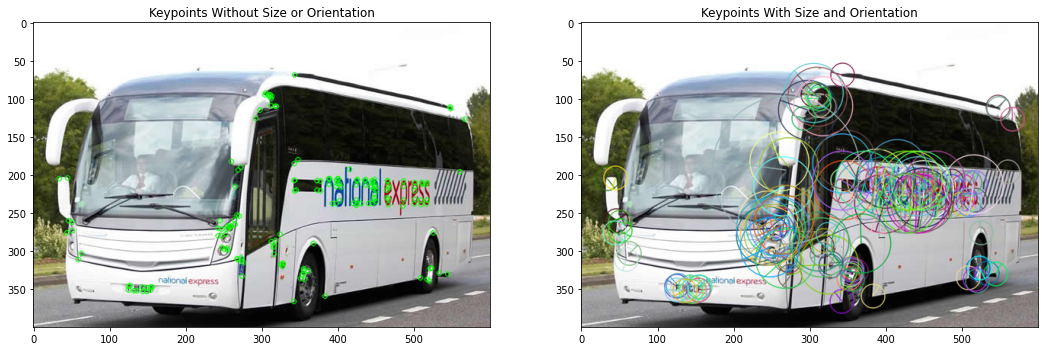


Number of keypoints Detected:  169


In [ ]:
# Import copy to make copies of the training image
import copy

# Set the default figure size
plt.rcParams['figure.figsize'] = [18.0, 9.0]

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(200, 2.5)

# Find the keypoints in the gray scale training image and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask.
keypoints, descriptor = orb.detectAndCompute(training_gray, None)

# Create copies of the training image to draw our keypoints on
keyp_without_size = copy.copy(training_image)
keyp_with_size = copy.copy(training_image)

# Draw the keypoints without size or orientation on one copy of the training image 
cv2.drawKeypoints(training_image, keypoints, keyp_without_size, color = (0, 255, 0))

# Draw the keypoints with size and orientation on the other copy of the training image
cv2.drawKeypoints(training_image, keypoints, keyp_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with the keypoints without size or orientation
plt.subplot(121)
plt.title('Keypoints Without Size or Orientation')
plt.imshow(keyp_without_size)

# Display the image with the keypoints with size and orientation
plt.subplot(122)
plt.title('Keypoints With Size and Orientation')
plt.imshow(keyp_with_size)
plt.show()

# Print the number of keypoints detected
print("\nNumber of keypoints Detected: ", len(keypoints))

As we can see in the right image, every keypoint has a center, a size, and an angle. The center determines the location of each keypoint in the image; the size of each keypoint is determined by the patch size used by BRIEF to create its feature vector; and the angle tells us the orientation of the keypoint as determined by rBRIEF.

Once the keypoints for the training image have been found and their corresponding ORB descriptor has been calculated, the same thing can be done for the query image. 

###3. Feature Matching

Once we have the ORB descriptors for *both* the training and query images, the final step is to perform keypoint matching between the two images using their corresponding ORB descriptors. This *matching* is usually performed by a matching function. One of the most commonly used matching functions is called *Brute-Force*.

In the code below we will use OpenCV’s `BFMatcher` class to compare the keypoints in the training and query images. The parameters of the Brute-Force matcher are setup using the `cv2.BFMatcher()`function. The parameters of the `cv2.BFMatcher()`function and their default values are given below:



`cv2.BFMatcher(normType = cv2.NORM_L2,
		 	  crossCheck = false)`

Parameters:

* **normType**  
Specifies the metric used to determine the quality of the match. By default, `normType = cv2.NORM_L2`, which measures the distance between two descriptors.  However, for binary descriptors like the ones created by ORB, the Hamming metric is more suitable. The Hamming metric determines the distance by counting the number of dissimilar bits between the binary descriptors. When the ORB descriptor is created using `WTA_K = 2`, two random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0 or 1.  Such output only occupies 1 bit, and therefore the ` cv2.NORM_HAMMING` metric should be used.  If, on the other hand, the ORB descriptor is created using `WTA_K = 3`, three random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0, 1, or 2.  Such output will occupy 2 bits, and therefore a special variant of the Hamming distance, known as the `cv2.NORM_HAMMING2` (the 2 stands for 2 bits), should be used instead. Then, for any metric chosen, when comparing the keypoints in the training and query images, the pair with the smaller metric (distance between them) is considered the best match.


* **crossCheck** - *bool* 
A Boolean variable and can be set to either `True` or `False`. Cross-checking is very useful for eliminating false matches. Cross-checking works by performing the matching procedure two times. The first time the keypoints in the training image are compared to those in the query image; the second time, however, the keypoints in the query image are compared to those in the training image (*i.e.* the comparison is done backwards). When cross-checking is enabled a match is considered valid only if keypoint *A* in the training image is the best match of keypoint *B* in the query image and vice-versa (that is, if keypoint *B* in the query image is the best match of point *A* in the training image). 

Read more about BGMatcher's parameters at: https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html

Once the parameters of the *BFMatcher* have been set, we can use the `.match(descriptors_train, descriptors_query)` method to find the matching  keypoints between the training and query images using their ORB descriptors. Finally, we will use the `cv2.drawMatches()` function to visualize the matching keypoints found by the Brute-Force matcher. This function stacks the training and query images horizontally and draws lines from the keypoints in the training image to their corresponding best matching keypoints in the query image. 

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


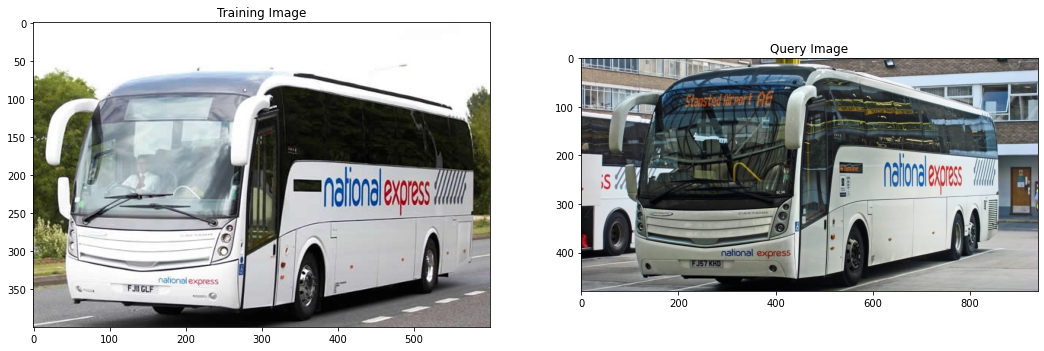

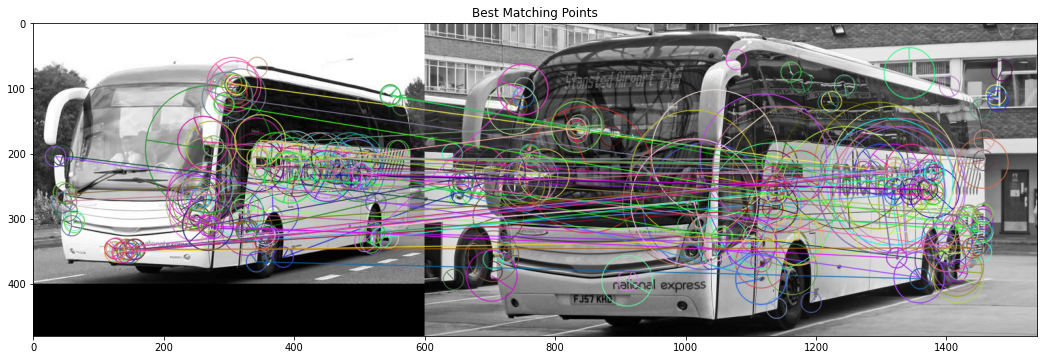

Number of Keypoints Detected In The Training Image:  169
Number of Keypoints Detected In The Query Image:  187

Number of Matching Keypoints Between The Training and Query Images:  57


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [18.0, 9.0]

# Load the training image
image1 = np.copy(image)

# Download the training image from the Internet
img_data = requests.get("https://media.thetab.com/blogs.dir/5/files/2018/02/doubledeckerbus-vehicle-transportation-bus-940x480.jpeg" , verify=False).content
with open('doubledeckerbus-vehicle-transportation-bus-940x480.jpeg', 'wb') as handler:
    handler.write(img_data)

# Load the query image
image2 = cv2.imread('doubledeckerbus-vehicle-transportation-bus-940x480.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the training and query images
plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)
plt.show()

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(200, 2.5)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 100 matches and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, since both the training and query images are quite similar but in different locations, we expect that the same number of keypoints are found in both images. We can clearly see that the Brute-Force matcher has been able to correctly match 64 keypoints in both training and query images.

# Exercise 1: Salt and pepper noise & Rotation 
Let's test ORB with noisy images! You will now have to implement a similar code but with a noisy (Salt and pepper) and rotated image query image. Is ORB still able to match keypoints? 

----

### SOLUTION:
Firt we added the images to the workspace


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


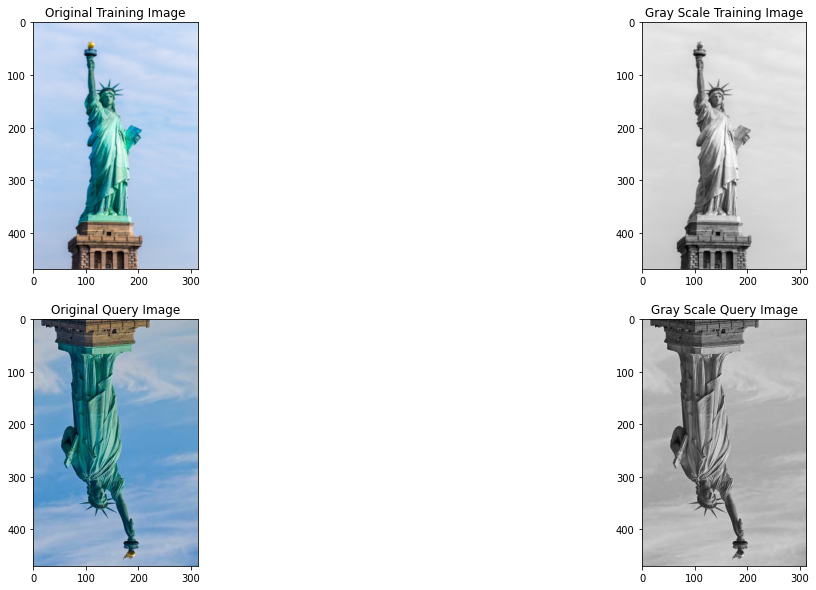

In [ ]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os, requests
import numpy as np

# Download the training image from the Internet
img_data1 = requests.get("https://image.freepik.com/foto-gratis/estatua-libertad-nueva-york-american-symbol-usa_79295-4240.jpg" , verify=False).content
with open('monument.jpg', 'wb') as handler:
    handler.write(img_data1)
img_data2 = requests.get("http://2.bp.blogspot.com/-UUuovOq2syo/TucaIwtyK6I/AAAAAAAAADY/yRyOwkSf1sQ/s1600/estatua-libertad.jpg" , verify=False).content
with open('monument2.jpg', 'wb') as handler:
    handler.write(img_data2)

# Load the training image
image1 = cv2.imread('monument.jpg')
image2 = cv2.imread('monument2.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
training_image = cv2.pyrDown(training_image)
# Convert the training image to gray Scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)


query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

width = training_image.shape[1] 
height = training_image.shape[0] 

# Rotate for the Query Image
query_image_M = cv2.getRotationMatrix2D((width//2,height//2),180,1)

# Convert the query image to gray scale
query_image =  cv2.warpAffine(query_image,query_image_M,(width,height))

# Convert the training image to gray Scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)


# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the images
plt.subplot(221)
plt.title('Original Training Image')
plt.imshow(training_image)
plt.subplot(222)
plt.title('Gray Scale Training Image')
plt.imshow(training_gray, cmap = 'gray')
plt.subplot(223)
plt.title('Original Query Image')
plt.imshow(query_image)
plt.subplot(224)
plt.title('Gray Scale Query Image')
plt.imshow(query_gray, cmap = 'gray')

plt.show()

As we can see, to test the matches of detected features, we rotate the image 180 degrees. Additionally we added Salt & Pepper noise.

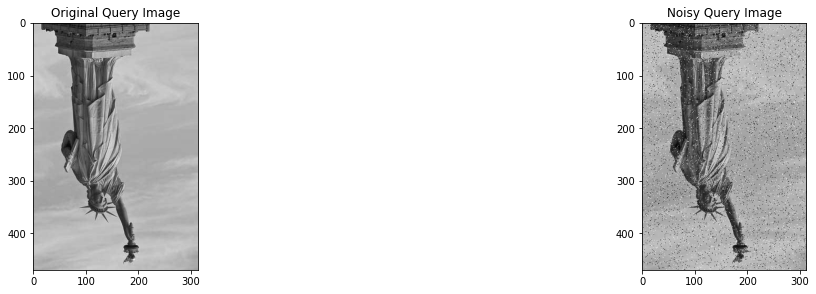

In [ ]:
from skimage.util import random_noise

query_gray_noise = random_noise(query_gray, mode='s&p',amount=0.05)

# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]
# Display the images
plt.subplot(221)
plt.title('Original Query Image')
plt.imshow(query_gray, cmap = 'gray')
plt.subplot(222)
plt.title('Noisy Query Image')
plt.imshow(query_gray_noise, cmap = 'gray')

Once the training image and the test image are practically different due to the noise applied and the rotation, we will apply the ORB algorithm to detect the features and find matches.

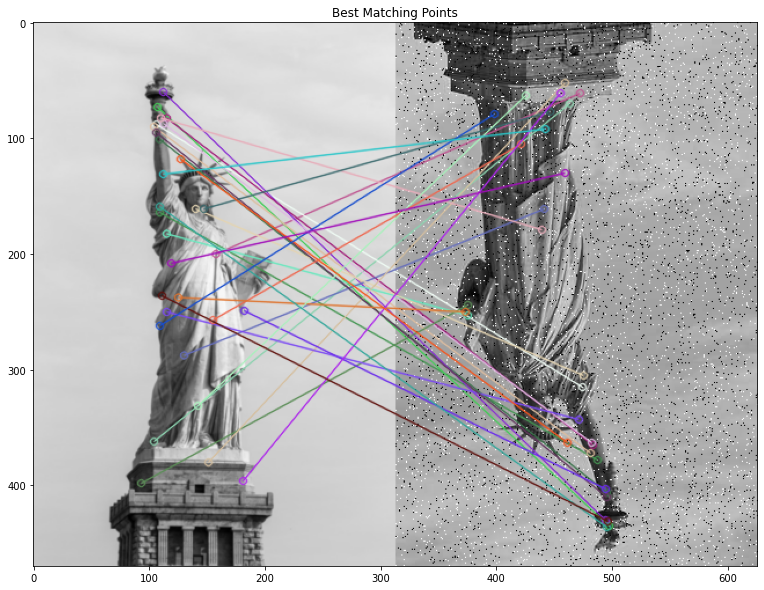

In [ ]:
# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(nfeatures=10000,scaleFactor = 2.5, edgeThreshold = 31, nlevels = 8) 
# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute((query_gray_noise*255).astype(np.uint8), None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 100 matches and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, (query_gray_noise*255).astype(np.uint8), keypoints_query, matches[:30], query_gray, flags = 2)


# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

As we can see even if we have modified the image, we will find many matching points between both images.

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("\nNumber of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

Number of Keypoints Detected In The Training Image:  823

Number of Keypoints Detected In The Query Image:  5074

Number of Matching Keypoints Between The Training and Query Images:  380


Analyzing the latest results, we can see that 823 features were found in the original image, 5074 in the query modified image, and 380 matching points were found between the two.

If we show the 380 coincidences found between the two images, we will see that several are unrelated, and in reality they may even be matching with the noise or other objects that are not in the training image. It should be noted that the modified image was not preprocessed precisely to test the scope of the ORB algorithm. 

The matches list will store the matches of the keypoints between both images with an ascending order (from lowest to highest) depending on the distance between matches, that is, the closer the distance is, the more similar. That is why in this case it was only chosen to show the first 30, in this way, satisfactory results can be seen.

# Exercise 2: Attendance system
In old times, lectures were completely on-site, and lecturers used to check attendance saying loudly the student's names. This practice used to take too much time so let's try to automate it for the time when we all return to the university in person. 

Your team will have to implement a way to verify if a person is present in a picture using ORB. To facilitate your work, you can use the following set of images: https://drive.google.com/drive/folders/1sY7rprDZCntVqzZ4cpc_DvYEkJ9--Tw3?usp=sharing

-----

### SOLUTION:

In a firt step, We will load all the images to the workspace, we will convert them to grayscale. Next we will define the parameters of the ORB algorithm with 10000 features.

In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import os, requests
import numpy as np

# Read the images
training_image = cv2.imread('class.jpeg')
training_image = cv2.cvtColor(training_image, cv2.COLOR_BGR2RGB)
image1 = cv2.imread('1.jpeg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('2.jpeg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.imread('3.jpeg')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.imread('4.jpeg')
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
image5 = cv2.imread('5.jpeg')
image5 = cv2.cvtColor(image5, cv2.COLOR_BGR2RGB)
image6 = cv2.imread('6.jpeg')
image6 = cv2.cvtColor(image6, cv2.COLOR_BGR2RGB)

# Convert the images to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
gray4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
gray5 = cv2.cvtColor(image5, cv2.COLOR_BGR2GRAY)
gray6 = cv2.cvtColor(image6, cv2.COLOR_BGR2GRAY)

# Create the ORB object parameters
orb = cv2.ORB_create(nfeatures=10000,scaleFactor = 2.0, edgeThreshold = 20, nlevels = 8) 
# Find the keypoints and descriptors for the training image
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
descriptorsList = []
accuracy_percentage = 0.15

We will work with the first student. To do this, we will compare the features found in the image of the entire class, with that of their individual face.

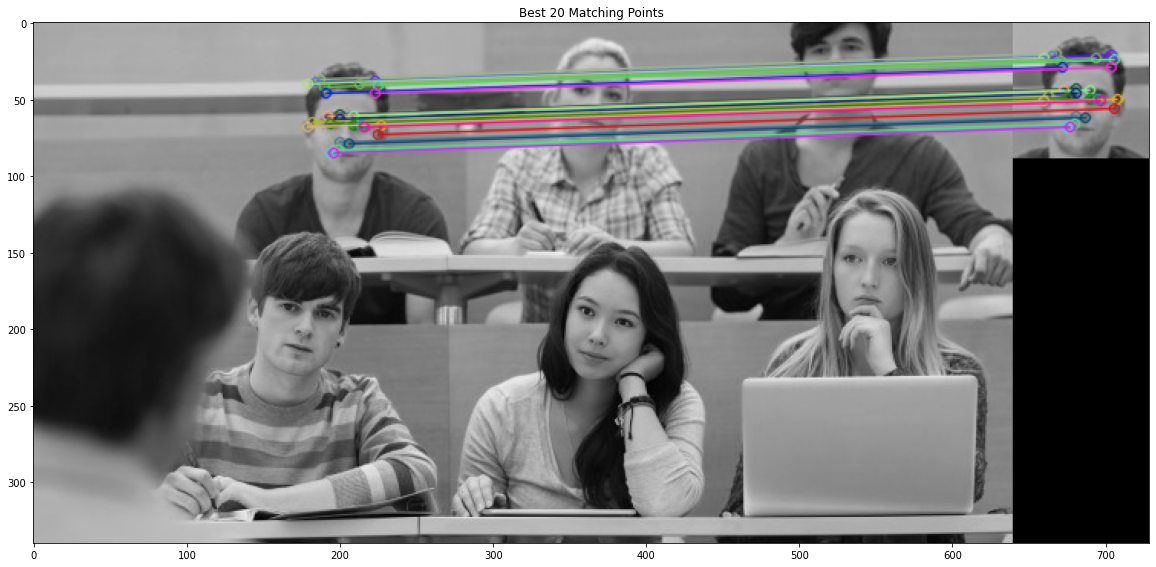

In [ ]:
# Find the keypoints and descriptors for the image of the student 1
keypoints_1, descriptors_1 = orb.detectAndCompute(gray1, None)
# Define the matching object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the training image and the student 1 image
matches = bf.knnMatch(descriptors_train, descriptors_1,k=2)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
# matches = sorted(matches, key = lambda x : x.distance)

good = []
for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])
# Connect the keypoints in the training image with their best matching keypoints in the student 1 image
result = cv2.drawMatchesKnn(training_gray, keypoints_train, gray1, keypoints_1, good, None, flags = 2)
descriptorsList.append(descriptors_1)
# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the best matching points
plt.title('Best 20 Matching Points')
plt.imshow(result)
plt.show()

Looking at the matches drawn, we can visually agree on what is in class. We will analyze more deeply based on the number of keypoints found

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image 1
print("\nNumber of Keypoints Detected In The Attendance Image 1: ", len(keypoints_1))

# Print total number of matching points between the training and image 1
print("\nNumber of Matching Keypoints Between The Training and The Attendance Image 1: ", len(good))

Number of Keypoints Detected In The Training Image:  2158

Number of Keypoints Detected In The Attendance Image 1:  31

Number of Matching Keypoints Between The Training and The Attendance Image 1:  26


As we can see, 2158 features were found in the image of the entire class and 26 in the student's face, between these two 31 matches were found, which means that all the features found in the individual image match those of the picture in class. Therefore, we could say that if he attended class.

----

Working with the student 2.

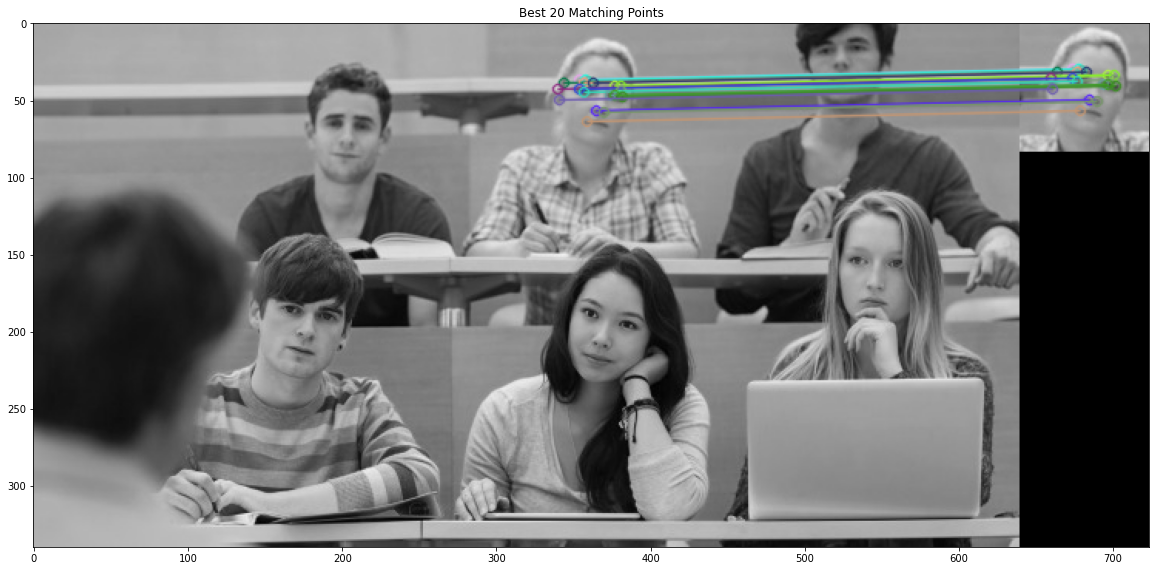

In [ ]:
# Find the keypoints and descriptors for the image of the student 1
keypoints_2, descriptors_2 = orb.detectAndCompute(gray2, None)
# Define the matching object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the training image and the student 1 image
matches = bf.knnMatch(descriptors_train, descriptors_2,k=2)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
# matches = sorted(matches, key = lambda x : x.distance)

good = []
for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])
# Connect the keypoints in the training image with their best matching keypoints in the student 1 image
result = cv2.drawMatchesKnn(training_gray, keypoints_train, gray2, keypoints_2, good, None, flags = 2)
descriptorsList.append(descriptors_2)
# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the best matching points
plt.title('Best 20 Matching Points')
plt.imshow(result)
plt.show()

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image 2
print("\nNumber of Keypoints Detected In The Attendance Image 2: ", len(keypoints_2))

# Print total number of matching points between the training and image 2
print("\nNumber of Matching Keypoints Between The Training and The Attendance Image 2: ", len(good))

Number of Keypoints Detected In The Training Image:  2158

Number of Keypoints Detected In The Attendance Image 2:  21

Number of Matching Keypoints Between The Training and The Attendance Image 2:  19


As we can see, 2158 features were found in the image of the entire class and 21 in the student's face, between these two 19 matches were found, which means that all the features found in the individual image match those of the picture in class. Therefore, we could say that if he attended class.

----

Working with the student 3.

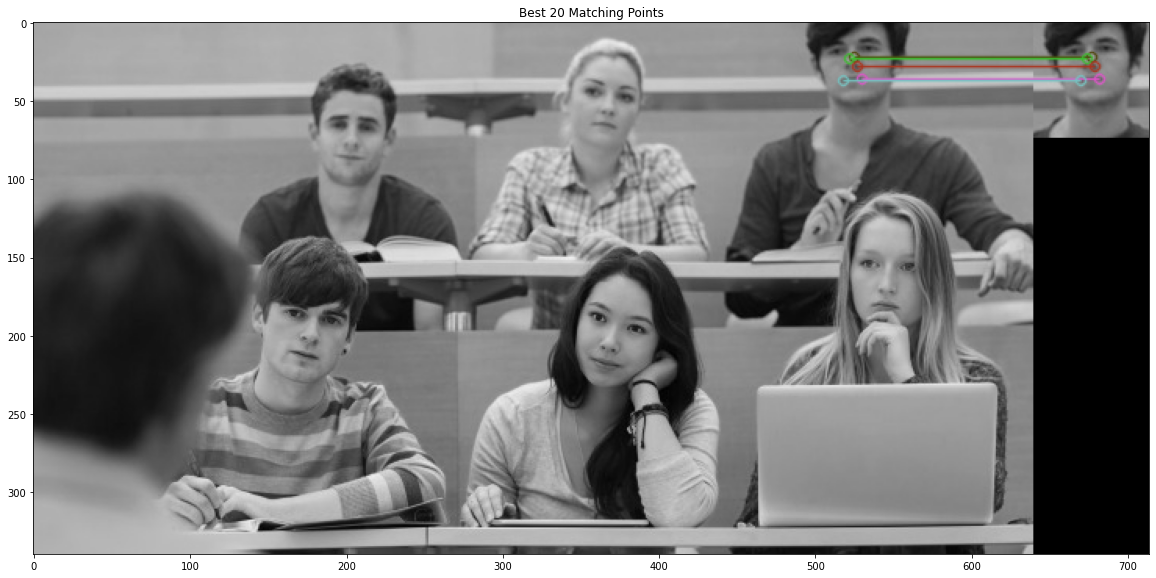

In [ ]:
# Find the keypoints and descriptors for the image of the student 1
keypoints_3, descriptors_3 = orb.detectAndCompute(gray3, None)
# Define the matching object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the training image and the student 1 image
matches = bf.knnMatch(descriptors_train, descriptors_3,k=2)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
# matches = sorted(matches, key = lambda x : x.distance)

good = []
for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])
# Connect the keypoints in the training image with their best matching keypoints in the student 1 image
result = cv2.drawMatchesKnn(training_gray, keypoints_train, gray3, keypoints_3, good, None, flags = 2)
descriptorsList.append(descriptors_3)
# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the best matching points
plt.title('Best 20 Matching Points')
plt.imshow(result)
plt.show()

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image 3
print("\nNumber of Keypoints Detected In The Attendance Image 3: ", len(keypoints_3))

# Print total number of matching points between the training and image 3
print("\nNumber of Matching Keypoints Between The Training and The Attendance Image 3: ", len(good))

Number of Keypoints Detected In The Training Image:  2158

Number of Keypoints Detected In The Attendance Image 3:  6

Number of Matching Keypoints Between The Training and The Attendance Image 3:  5


As we can see, 2158 features were found in the image of the entire class and 6 in the student's face, between these two 5 matches were found. Analyzing this case we can notice that something strange is happening, being that the number of features found in the image of the face of student 3 has dropped drastically and consequently the number of coincidences. This behavior can be explained with the low quality of the student 3 face image, due to its low resolution and smoothing it is possible that some features are not being detected.

Based on this, later we will define a parameter to decide if a student attended class with the processing performed.

----

Working with the student 4.

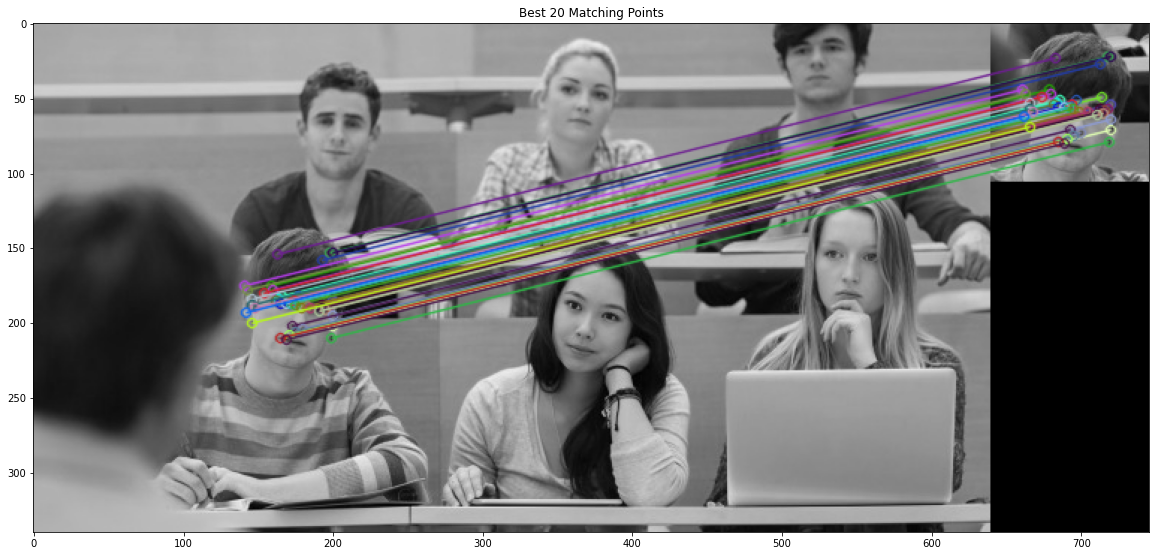

In [ ]:
# Find the keypoints and descriptors for the image of the student 1
keypoints_4, descriptors_4 = orb.detectAndCompute(gray4, None)
# Define the matching object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the training image and the student 1 image
matches = bf.knnMatch(descriptors_train, descriptors_4,k=2)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
# matches = sorted(matches, key = lambda x : x.distance)

good = []
for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])
# Connect the keypoints in the training image with their best matching keypoints in the student 1 image
result = cv2.drawMatchesKnn(training_gray, keypoints_train, gray4, keypoints_4, good, None, flags = 2)
descriptorsList.append(descriptors_4)
# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the best matching points
plt.title('Best 20 Matching Points')
plt.imshow(result)
plt.show()

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image 4
print("\nNumber of Keypoints Detected In The Attendance Image 4: ", len(keypoints_4))

# Print total number of matching points between the training and image 4
print("\nNumber of Matching Keypoints Between The Training and The Attendance Image 3: ", len(good))

Number of Keypoints Detected In The Training Image:  2158

Number of Keypoints Detected In The Attendance Image 4:  65

Number of Matching Keypoints Between The Training and The Attendance Image 3:  43


As we can see, 2158 features were found in the image of the entire class and 65 in the student's face, between these two 43 matches were found, which means that all the features found in the individual image match those of the picture in class. Therefore, we could say that if he attended class. Note that this is one of the best results found so far, as several traits were found.

----

Working with the student 5.

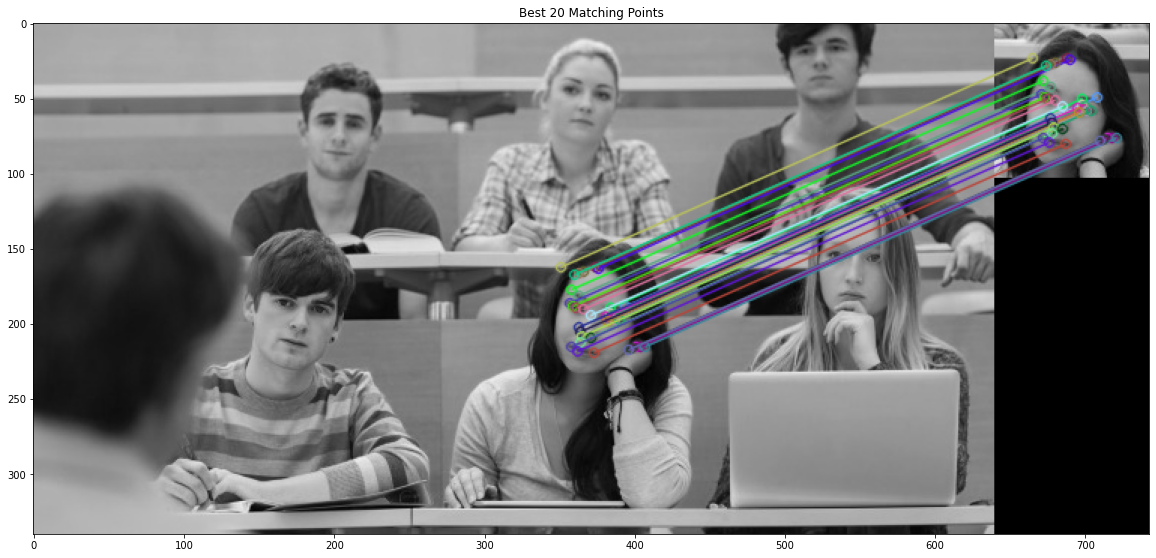

In [ ]:
# Find the keypoints and descriptors for the image of the student 1
keypoints_5, descriptors_5 = orb.detectAndCompute(gray5, None)
# Define the matching object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the training image and the student 1 image
matches = bf.knnMatch(descriptors_train, descriptors_5,k=2)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
# matches = sorted(matches, key = lambda x : x.distance)

good = []
for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])
# Connect the keypoints in the training image with their best matching keypoints in the student 1 image
result = cv2.drawMatchesKnn(training_gray, keypoints_train, gray5, keypoints_5, good, None, flags = 2)
descriptorsList.append(descriptors_5)
# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the best matching points
plt.title('Best 20 Matching Points')
plt.imshow(result)
plt.show()

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image 5
print("\nNumber of Keypoints Detected In The Attendance Image 5: ", len(keypoints_5))

# Print total number of matching points between the training and image 5
print("\nNumber of Matching Keypoints Between The Training and The Attendance Image 3: ", len(good))

Number of Keypoints Detected In The Training Image:  2158

Number of Keypoints Detected In The Attendance Image 5:  46

Number of Matching Keypoints Between The Training and The Attendance Image 3:  36


As we can see, 2158 features were found in the image of the entire class and 46 in the student's face, between these two 36 matches were found, which means that all the features found in the individual image match those of the picture in class. Therefore, we could say that if he attended class.

----

Working with the student 6.

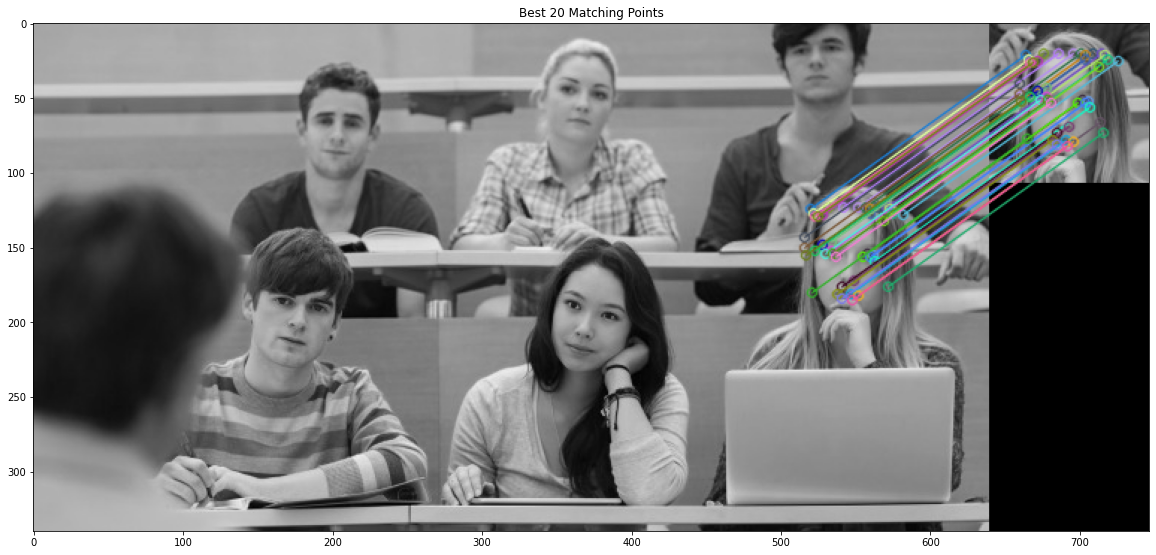

In [ ]:
# Find the keypoints and descriptors for the image of the student 1
keypoints_6, descriptors_6 = orb.detectAndCompute(gray6, None)
# Define the matching object
bf = cv2.BFMatcher()
# Perform the matching between the ORB descriptors of the training image and the student 1 image
matches = bf.knnMatch(descriptors_train, descriptors_6,k=2)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
# matches = sorted(matches, key = lambda x : x.distance)

good = []
for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])
# Connect the keypoints in the training image with their best matching keypoints in the student 1 image
result = cv2.drawMatchesKnn(training_gray, keypoints_train, gray6, keypoints_6, good, None, flags = 2)
descriptorsList.append(descriptors_6)
# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the best matching points
plt.title('Best 20 Matching Points')
plt.imshow(result)
plt.show()

In [ ]:
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image 6
print("Number of Keypoints Detected In The Attendance Image 6: ", len(keypoints_6))

# Print total number of matching points between the training and image 6
print("\nNumber of Matching Keypoints Between The Training and The Attendance Image 3: ", len(good))

Number of Keypoints Detected In The Training Image:  2158
Number of Keypoints Detected In The Attendance Image 6:  58

Number of Matching Keypoints Between The Training and The Attendance Image 3:  42


As we can see, 2158 features were found in the image of the entire class and 58 in the student's face, between these two 42 matches were found, which means that all the features found in the individual image match those of the picture in class. Therefore, we could say that if he attended class.

----

As mentioned before, to finish this challenge, we will define a parameter of 20 metches to decide if we can affirm that a student attended class or not.

In [ ]:
min_matches = 15
result= []
matchList = []
students = {1: 'Estudiante 1', 2: 'Estudiante 2',3: 'Estudiante 3', 4: 'Estudiante 4', 5: 'Estudiante 5', 6: 'Estudiante 6'}

for des in descriptorsList:
  bf2 = cv2.BFMatcher()
  matches = bf2.knnMatch(descriptors_train,des,k=2)
  
  good = []
  for m,n in matches:
    if m.distance < accuracy_percentage*n.distance:
        good.append([m])

  matchList.append(len(good))

index = 0
for match in matchList:
  index += 1
  if match > min_matches:
    result.append(index)
print('Los Estudiantes que asistieron a clase según el código desarrollado son:\n')
for r in result:
  print(f'- {students[r]}')

Los Estudiantes que asistieron a clase según el código desarrollado son:

- Estudiante 1
- Estudiante 2
- Estudiante 4
- Estudiante 5
- Estudiante 6
